# Time Series analysis of O'hare taxi rides data

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
pd.set_option('display.max_rows', 6)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16,
                     'axes.labelweight': 'bold',
                     'figure.figsize': (8,6)})
from mealprep.mealprep import find_missing_ingredients
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
import pickle

In [2]:
ORD_df = pd.read_csv('../data/ORD_train.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [3]:
ORD_df

,year,month,day,hour,rides,tmpf,dwpf,relh,sknt,p01i,vsby,feel,skyc,seats,airline
0,2013,1,1,0,22,24.98,17.96,74.290,9.000000,0.0,9.0,14.78,3.000000,464.952671,3.0
1,2013,1,1,1,9,24.89,17.78,73.995,9.000000,0.0,8.0,14.67,5.000000,148.479860,1.0
2,2013,1,1,2,11,21.20,14.00,73.320,10.000000,0.0,9.0,9.42,5.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43759,2017,12,31,21,62,10.90,-4.00,50.280,12.307692,0.0,10.0,-5.46,0.230769,1452.166804,10.0
43760,2017,12,31,22,53,9.00,-4.00,54.740,11.666667,0.0,10.0,-5.09,0.307692,1339.417038,9.0
43761,2017,12,31,23,30,7.00,-5.10,56.830,9.538462,0.0,10.0,-8.38,0.153846,1990.140502,11.0


## Tom's functions

In [4]:
# Custom functions
def lag_df(df, lag, cols):
    return df.assign(**{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols})


def ts_predict(input_data, model, n=20, responses=1):
    predictions = []
    n_features = input_data.size
    for _ in range(n):

        predictions = np.append(predictions,
                                model.predict(input_data.reshape(1, -1)))  # make prediction
        input_data = np.append(predictions[-responses:],
                               input_data[:n_features-responses])  # new input data
    return predictions.reshape((-1, responses))


def plot_ts(ax, df_train, df_test, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(df_test[col], '--', c=col_cycle[i], label = f'Validation {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+1)
    ax.set_title(f"Train Shape = {len(df_train)}, Validation Shape = {len(df_test)}",
                fontsize=16)
    ax.set_ylabel(df_train.columns[0])

        
def plot_forecast(ax, df_train, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], '-', c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+len(predictions))
    ax.set_title(f"{len(predictions)}-step forecast",
                    fontsize=16)
    ax.set_ylabel(response_cols)
    
def create_rolling_features(df, columns, windows=[6, 12]):
    for window in windows:
        df["rolling_mean_" + str(window)] = df[columns].rolling(window=window).mean()
        df["rolling_std_" + str(window)] = df[columns].rolling(window=window).std()
        df["rolling_var_" + str(window)] = df[columns].rolling(window=window).var()
        df["rolling_min_" + str(window)] = df[columns].rolling(window=window).min()
        df["rolling_max_" + str(window)] = df[columns].rolling(window=window).max()
        df["rolling_min_max_ratio_" + str(window)] = df["rolling_min_" + str(window)] / df["rolling_max_" + str(window)]
        df["rolling_min_max_diff_" + str(window)] = df["rolling_max_" + str(window)] - df["rolling_min_" + str(window)]

    df = df.replace([np.inf, -np.inf], np.nan)    
    df.fillna(0, inplace=True)
    return df

In [9]:

lag = 3
ORD_train_lag = lag_df(ORD_df, lag=lag, cols=['seats']).dropna()

In [10]:
ORD_train_lag

,year,month,day,hour,rides,tmpf,dwpf,relh,sknt,p01i,vsby,feel,skyc,seats,airline,seats-1,seats-2,seats-3
7,2013,1,1,7,7,19.04,8.06,61.72,9.000000,0.0,10.0,7.40,5.000000,4108.664518,49.0,1244.810412,1306.835280,860.523798
8,2013,1,1,8,24,17.96,8.06,64.65,10.000000,0.0,10.0,5.36,3.000000,5830.170584,58.0,4108.664518,1244.810412,1306.835280
9,2013,1,1,9,38,15.98,6.98,67.07,12.000000,0.0,10.0,1.61,2.000000,4651.462689,47.0,5830.170584,4108.664518,1244.810412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43759,2017,12,31,21,62,10.90,-4.00,50.28,12.307692,0.0,10.0,-5.46,0.230769,1452.166804,10.0,2196.333217,4638.370834,6271.002507
43760,2017,12,31,22,53,9.00,-4.00,54.74,11.666667,0.0,10.0,-5.09,0.307692,1339.417038,9.0,1452.166804,2196.333217,4638.370834
43761,2017,12,31,23,30,7.00,-5.10,56.83,9.538462,0.0,10.0,-8.38,0.153846,1990.140502,11.0,1339.417038,1452.166804,2196.333217


In [11]:
find_missing_ingredients(ORD_train_lag)

'There are no missing values'

In [17]:
lag = 3  # you can vary the number of lagged features in the model
n_splits = 5  # you can vary the number of train/validation splits
response_col = ['rides']
# df_lag = lag_df(df, lag, response_col).dropna()
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # define the model

cv = cross_validate(model,
                    X = ORD_train_lag.drop(columns=response_col),
                    y = ORD_train_lag[response_col[0]],
                    scoring =('r2', 'neg_mean_squared_error'),
                    cv=tscv,
                    return_train_score=True)




# pd.DataFrame({'split': range(n_splits),
#               'train_r2': cv['train_score'],
#               'train_negrmse': cv['train_']
#               'validation_r2': cv['test_score']}).set_index('split')

In [19]:
pd.DataFrame(cv)

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error
0,3.757084,0.080120,-0.124749,0.969451,-14626.698599,-183.676532
1,7.895703,0.080302,0.663738,0.971834,-5427.333730,-303.579649
2,12.600834,0.100969,0.641493,0.972693,-5842.216327,-368.602844
3,17.659588,0.104724,0.718446,0.973842,-5841.529604,-381.196058
4,23.248862,0.123709,0.658929,0.973145,-6487.237181,-430.244639


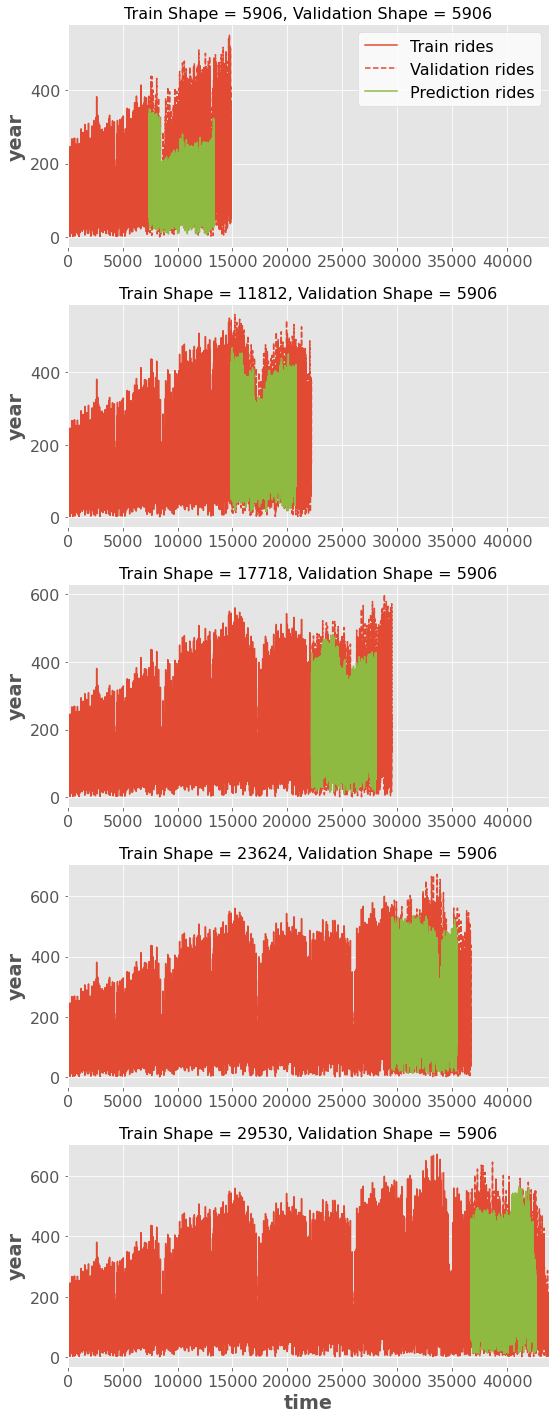

In [20]:
fig, ax = plt.subplots(n_splits, 1, figsize=(8,4*n_splits))
for i, (train_index, test_index) in enumerate(tscv.split(ORD_train_lag)):
    df_train, df_test = ORD_train_lag.iloc[train_index], ORD_train_lag.iloc[test_index]
    model = RandomForestRegressor().fit(df_train.drop(columns=response_col),
                                        df_train[response_col[0]])  # train model
    # Prediction loop
    predictions = model.predict(df_test.drop(columns=response_col))[:,None]

    # Plot
    plot_ts(ax[i], df_train, df_test, predictions, xlim=ORD_train_lag.index[-1], response_cols=response_col)
ax[0].legend(facecolor='w')
ax[i].set_xlabel('time')
fig.tight_layout()

In [37]:
lag = 3  # you can vary the number of lagged features in the model
n_splits = 3  # you can vary the number of train/validation splits
response_col = ['rides']
# df_lag = lag_df(df, lag, response_col).dropna()
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # define the model
param_grid = {'n_estimators': [50, 100, 150, 200],
              'max_depth': [10,25,50,100, None]}

X = ORD_train_lag.drop(columns=response_col)
y = ORD_train_lag[response_col[0]]


gcv = GridSearchCV(model,
                   param_grid = param_grid,
#                     X = ORD_train_lag.drop(columns=response_col),
#                     y = ORD_train_lag[response_col[0]],
                    scoring ='neg_mean_squared_error',
                    cv=tscv,
                    return_train_score=True)


gcv.fit(X,y)

# pd.DataFrame({'split': range(n_splits),
#               'train_r2': cv['train_score'],
#               'train_negrmse': cv['train_']
#               'validation_r2': cv['test_score']}).set_index('split')

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbo

In [38]:
gcv.score(X,y)

-443.22927681383334

In [ ]:
filename = 'grid_search_model_1.sav'
pickle.dump(gcv, open(filename, 'wb'))

In [54]:
A = list(ORD_train_lag.columns)
A.remove('rides')

In [60]:
pd.DataFrame({'columns' : A, 'importance' : gcv.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)

,columns,importance
15,seats-2,0.440807
0,year,0.115074
14,seats-1,0.096950
3,hour,0.068694
16,seats-3,0.055891
1,month,0.042822
12,seats,0.033242
2,day,0.030268
10,feel,0.017671
6,relh,0.017644


In [59]:
gcv.best_params_

{'max_depth': None, 'n_estimators': 200}

In [62]:
pd.DataFrame(gcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.939436,1.666981,0.029561,0.001290,10,50,"{'max_depth': 10, 'n_estimators': 50}",-6527.794521,-6137.051659,-6580.936116,-6415.260765,197.916207,20,-884.199421,-1887.111793,-2627.784147,-1799.698453,714.494107
1,7.982939,3.473600,0.058221,0.002238,10,100,"{'max_depth': 10, 'n_estimators': 100}",-6433.167589,-6110.312917,-6546.407795,-6363.296101,184.763280,17,-874.359477,-1866.451133,-2606.655387,-1782.488666,709.694560
2,12.100326,4.857998,0.086990,0.003519,10,150,"{'max_depth': 10, 'n_estimators': 150}",-6356.590911,-6113.649930,-6577.360724,-6349.200522,189.381253,15,-870.368937,-1872.156534,-2606.380275,-1782.968582,711.524049
3,15.746890,6.667714,0.113986,0.002104,10,200,"{'max_depth': 10, 'n_estimators': 200}",-6471.669553,-6077.122266,-6532.357151,-6360.382990,201.822074,16,-868.289303,-1867.336835,-2592.710388,-1776.112176,706.941051
4,6.430274,2.963336,0.066558,0.018069,25,50,"{'max_depth': 25, 'n_estimators': 50}",-6337.525553,-6134.493794,-6518.895690,-6330.305013,157.014451,14,-223.705117,-394.829318,-439.384746,-352.639727,92.967366
5,12.848485,5.927394,0.130796,0.035675,25,100,"{'max_depth': 25, 'n_estimators': 100}",-6305.206489,-6051.308188,-6442.795813,-6266.436830,162.158266,3,-215.592576,-371.951462,-419.721186,-335.755075,87.177047
6,19.904958,9.483752,0.198635,0.055416,25,150,"{'max_depth': 25, 'n_estimators': 150}",-6368.337751,-6042.150679,-6450.717901,-6287.068777,176.418590,8,-212.450813,-368.867812,-412.304495,-331.207707,85.825739
7,25.790248,11.881891,0.260682,0.071671,25,200,"{'max_depth': 25, 'n_estimators': 200}",-6288.945401,-6043.213161,-6468.629489,-6266.929351,174.371811,4,-208.637479,-365.826258,-408.991680,-327.818472,86.096439
8,6.525546,3.063670,0.067998,0.019381,50,50,"{'max_depth': 50, 'n_estimators': 50}",-6468.323606,-6110.854107,-6514.270076,-6364.482596,180.320691,18,-220.056728,-386.053465,-435.567413,-347.225868,92.166156
9,12.922370,5.914141,0.129482,0.034128,50,100,"{'max_depth': 50, 'n_estimators': 100}",-6339.388758,-6053.169385,-6490.136211,-6294.231451,181.226173,9,-213.964864,-373.550722,-415.727811,-334.414466,86.893830


In [41]:
gcv.estimator.best_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)